# Shell and Tube Calculator for Heat Storage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import param

## LMTD Method of Solving Heat Exchanger Outlet Temperatures

Simplified model where the overall heat transfer coefficient is a simple function of the Reynolds number and the number of plates for the side with the lowest Reynolds number. It is also a function of the heat transfer area of course.

In [2]:
def plate_U(Re,no_plates): #Overall heat transfer coefficient based on Reynolds number and number of plates
    return Re/no_plates + 1800 #W/m^2/K

### Heat Flow: LMTD Function based on the heat exchanger parameters and the log mean temperature difference

In [3]:
def Qlm(Tshell,Ttube,Re,no_plates,area):
    U = plate_U(Re,no_plates)
    DT1 = Tshell[0]-Ttube[0]
    DT2 = Tshell[1]-Ttube[1]
    if DT1 == DT2:
        DTLM = DT1
    else:
        DTLM = (DT1 - DT1)/np.log(DT2/DT2)
    return abs(U*area*DTLM)


### Heat Flow: Fluid Properties

In [4]:
def Qflow(mdot,Cp,T):
    return mdot*Cp*abs(T[0]-T[1])

### Substance Definition

In [5]:
class substance(param.Parameterized):
    mdot = param.Number(1.0, doc='Mass flow rate [kg/s]')
    Cp = param.Number(4186, doc='Specific heat capacity [J/kg/K]')
    rho = param.Number(1000, doc='Density [kg/m^3]')
    mu = param.Number(1.0e-3, doc='Dynamic viscosity [Pa s]')

    def Re(self,D): #Reynold in the entry pipe, m/s
        vel = self.mdot/(np.pi/4*D**2*self.rho)
        return self.rho*vel*D/self.mu

### Initialization

In [6]:
#scenario
multiplier = 0.25
#water
water = substance(mdot=1*multiplier)

#oil
oil = substance(mdot=1*multiplier,Cp=2000,rho=920,mu=0.04)

#heat exchanger
area = 0.46 #m^2
no_plates = 20

#pipe size for Reynolds number calculation
D = 0.824*0.0254 #m 3/4" pipe 

Rew = water.Re(D)
Reo = oil.Re(D)

print('Reynolds number for water:',Rew)
print('Reynolds number for oil:',Reo)

Reynolds number for water: 7604.299322103401
Reynolds number for oil: 380.21496610517


In [7]:
#initial conditions
Oilinlet = 25
Waterinlet = 40

### Error function for LMTD method

In [8]:
def error(Temps, Waterinlet, Oilinlet):
    Wateroutlet = Temps[0]
    Oiloutlet = Temps[1]
    
    Twater = [Waterinlet,Wateroutlet] #inlet and outlet
    Toil = [Oiloutlet, Oilinlet] #inlet and outlet

    #Heat flow
    Qw = Qflow(water.mdot,water.Cp,Twater)
    Qo = Qflow(water.mdot,oil.Cp,Toil)
    #print('Heat flow water:',Qw)
    #print('Heat flow oil:',Qo)

    #Heat transfer flow
    Qlmo = Qlm(Twater,Toil,Reo,no_plates,area)
    #print('LM Heat transfer flow oil:',Qlmo)

    return np.array([abs(Qw-Qlmo), abs(Qw-Qw)])


### Solution Estimate

In [9]:
aveguess = (Oilinlet+Waterinlet)/2
guess = [aveguess-0.1,aveguess] #initial guess for water and oil outlet temperatures
Tout = fsolve(error,guess, args=(Waterinlet,Oiloutlet))
print('Water outlet temperature:',Tout[0])
print('Oil outlet temperature:',Tout[1])
print('Heat transfer water:',Qlm([Waterinlet,Tout[0]],[Tout[1],Oilinlet],Reo,no_plates,area))
print('Heat transfer oil:',Qflow(oil.mdot,oil.Cp,[Tout[1],Oilinlet]))
HeatTransfer1 = Qflow(water.mdot,water.Cp,[Waterinlet,Tout[0]])
print('Heat transfer water:',HeatTransfer1)


Water outlet temperature: 30.902904978484802
Oil outlet temperature: 34.52010994001565
Heat transfer water: 4760.054970007154
Heat transfer oil: 4760.054970007825
Heat transfer water: 4760.054970007827


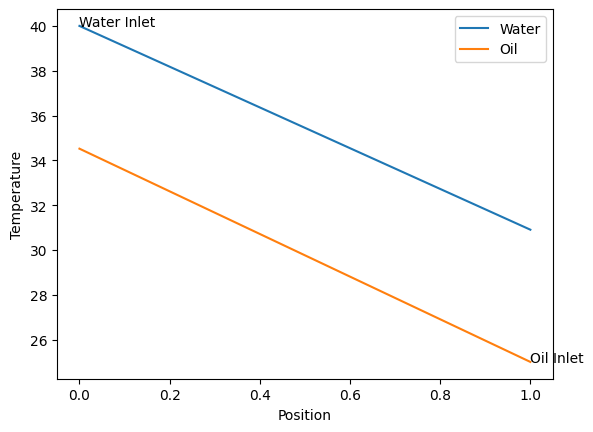

In [10]:
#plot the temperature profiles for the water and oil
Twater = [Waterinlet,Tout[1]]
Toil = [Tout[1],Oilinlet]
x = np.linspace(0,1,100)
Twp = (Twater[1]- Twater[0])*x + Twater[0]
Top = (Toil[0]- Toil[0])*x + Toil[0]

plt.plot(x,Twp,label='Water')
plt.plot(x,Top,label='Oil')
plt.xlabel('Position')
plt.ylabel('Temperature')
#add label to water inlet and outlet
plt.text(0,Twater[0],'Water Inlet')
plt.text(1,Toil[1],'Oil Inlet')
plt.legend()
plt.show()

## Now back the other way

In [11]:
#initial conditions
Oilinlet2 = Toil[0]
Waterinlet2 = Twater[1]
Oilinlet2, Waterinlet2

(34.52010994001565, 30.902904978484802)

In [12]:
aveguess = (Oilinlet2+Waterinlet2)/2
guess = [aveguess+0.3,aveguess] #initial guess for water and oil outlet temperatures
Tout2 = fsolve(error,guess, args=(Waterinlet2,Oilinlet2))
print('Water outlet temperature:',Tout2[0])
print('Oil outlet temperature:',Tout2[1])
print('Heat transfer water:',Qlm([Waterinlet2,Tout2[0]],[Tout2[1],Oilinlet2],Reo,no_plates,area))
print('Heat transfer oil:',Qflow(oil.mdot,oil.Cp,[Tout2[1],Oilinlet2]))
HeatTransfer2 = Qflow(water.mdot,water.Cp,[Waterinlet2,Tout2[0]])
print('Heat transfer water:',HeatTransfer2)

Water outlet temperature: 33.09664212831173
Oil outlet temperature: 32.22436401272179
Heat transfer water: 1147.8729636411233
Heat transfer oil: 1147.8729636469288
Heat transfer water: 1147.8729636469393


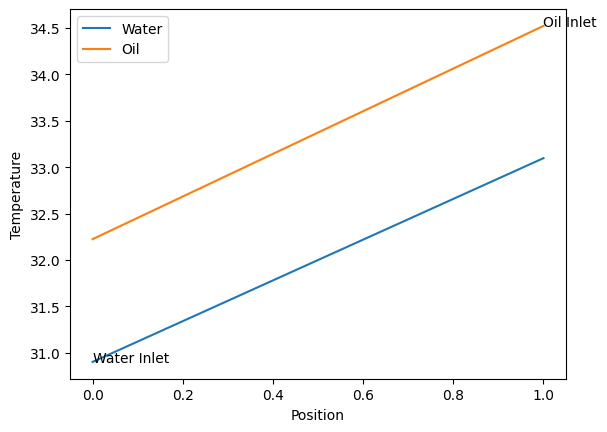

In [13]:
#plot the temperature profiles for the water and oil
Twater2 = [Waterinlet2,Tout2[0]]
Toil2 = [Tout2[1],Oilinlet2]
x = np.linspace(0,1,100)
Twp = (Twater2[1]- Twater2[0])*x + Twater2[0]
Top = (Toil2[0]- Toil2[1])*x + Toil2[0]

plt.plot(x,Twp,label='Water')
plt.plot(x,Top,label='Oil')
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.text(0,Twater2[0],'Water Inlet')
plt.text(1,Toil2[1],'Oil Inlet')
plt.legend()
plt.show()

In [14]:
Efficiency = HeatTransfer2/HeatTransfer1
print(f'Effectiveness: {Efficiency:.2f}')

Effectiveness: 0.24


In [15]:
water.mdot

0.125

### Solution Results

In [16]:
results = {'Water Flow, kg/s':[0.185,0.175,0.15,0.125,0.1,0.075,0.05,0.025,0.0125,0.01],'Effeciency':[0.05,0.08,0.15,0.24,0.34,0.46,0.6,0.78,0.88,0.9],'Heat Transfer, W':[314,462,822,1147,1408,1550,1487,1061,633,524]}

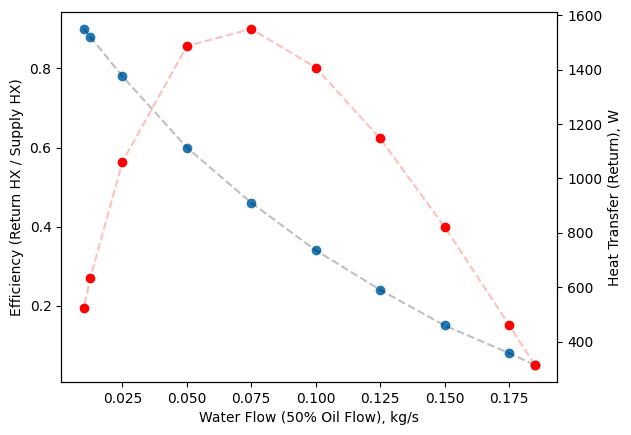

In [17]:
plt.scatter(results['Water Flow, kg/s'],results['Effeciency'])
plt.plot(results['Water Flow, kg/s'],results['Effeciency'],'k--',alpha=0.25)
plt.xlabel('Water Flow (50% Oil Flow), kg/s')
plt.ylabel('Efficiency (Return HX / Supply HX)')
#add second y axis
plt.twinx()
plt.scatter(results['Water Flow, kg/s'],results['Heat Transfer, W'],color='r')
plt.plot(results['Water Flow, kg/s'],results['Heat Transfer, W'],'r--',alpha=0.25)
plt.ylabel('Heat Transfer (Return), W')
plt.show()
